In [1]:
from rasterio.warp import reproject, Resampling
import rasterio as rio
from affine import Affine
import numpy as np

import matplotlib.pyplot as plt
import rasterio as rio

import rasterio as rio
import numpy as np
import json



In [3]:
def rotate_raster(in_file,out_file, angle, shift_x=0, shift_y=0,adj_width=0, adj_height=0):
    """Rotate a raster image and save it to disk.
            in_file: path to input raster file
            out_file: path to output raster file
            angle: angle of rotation in degrees
            shift_x: shift in x direction
            shift_y: shift in y direction
            adj_width: adjust width of output raster
            adj_height: adjust height of output raster"""

    with rio.open(in_file) as src:

        # Get the old transform and crs
        src_transform = src.transform 
        crs = src.crs

        # Affine transformations for rotation and translation
        rotate = Affine.rotation(angle)
        trans_x = Affine.translation(shift_x,0)
        trans_y = Affine.translation(0, -shift_y)

        # Combine affine transformations
        dst_transform = src_transform * rotate * trans_x * trans_y

        # Get band data
        band = np.array(src.read(1))

        # Get the new shape
        y,x = band.shape
        dst_height = y + adj_height
        dst_width = x + adj_width

        # set properties for output
        dst_kwargs = src.meta.copy()
        dst_kwargs.update(
            {
                "transform": dst_transform,
                "height": dst_height,
                "width": dst_width,
                "nodata": 0,  
            }
        )

        # write to disk
        with rio.open(out_file, "w", **dst_kwargs) as dst:
            # reproject to new CRS

            reproject(source=band,
                        destination=rio.band(dst, 1),
                        src_transform=src_transform,
                        src_crs=crs,
                        dst_transform=dst_transform,
                        dst_crs=crs,
                        resampling=Resampling.nearest)

In [6]:
in_file = "Clipped(2016)_meter.tif"
out_file = in_file.replace(".tif", "_rotated.tif")
output_geojson_path = "max_elevations_2016.geojson"

(10942, 14199)


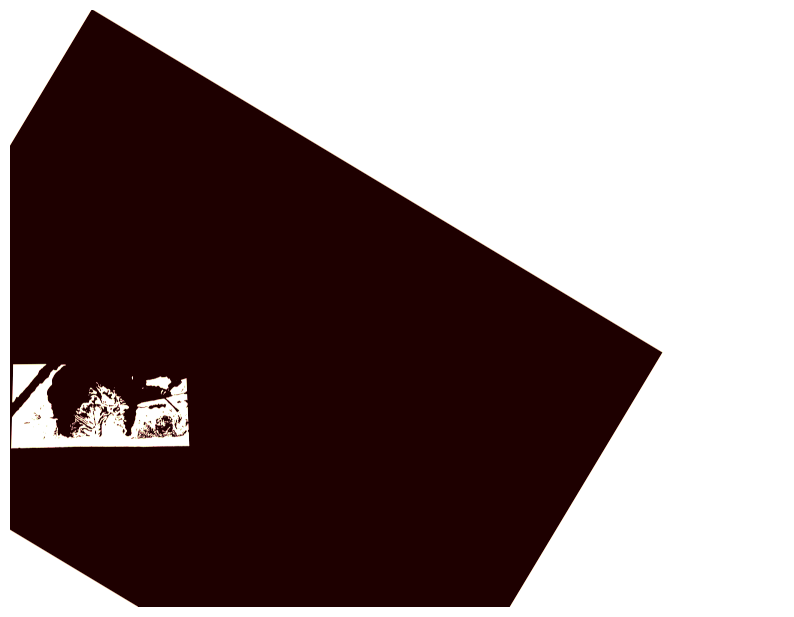

In [7]:




rotate_raster(in_file,out_file, angle=-31, shift_x=-1500, shift_y=0, adj_width=2000, adj_height=2000)

# Open the red band (B4):

src = rio.open(out_file)
# Get the old transform and crs
src_transform = src.transform 
crs = src.crs
band1 = src.read(1)

print(src.shape)

# Display the band
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(src.read(1), cmap='pink')

ax.set_axis_off()



In [8]:



def process_rotated_raster(rotated_file, output_geojson_path):
    geojson_features = []

    with rio.open(rotated_file) as src:
        # Use the updated transform from the rotated raster
        updated_transform = src.transform

        band1 = src.read(1)

        for x in range(band1.shape[1]):
            max_value = np.max(band1[:, x])
            y = np.argmax(band1[:, x])
            

            if max_value == 0 and y == 0:
                continue
            
            if -3.4028235e+38 < -10 and y == 0:
                continue

            # Calculate lon, lat using the updated transform
            lon, lat = updated_transform * (x, y)

            feature = {
                "type": "Feature",
                "properties": {"elevation": float(max_value)},
                "geometry": {
                    "type": "Point",
                    "coordinates": [lon, lat]
                }
            }
            geojson_features.append(feature)

        if not geojson_features:
            print("No valid features found")
        else:
            geojson_data = {
                "type": "FeatureCollection",
                "features": geojson_features
            }

            with open(output_geojson_path, 'w') as f:
                json.dump(geojson_data, f)

# Example usage






In [9]:
# rotate_raster(in_file,out_file, angle=-31, shift_x=-1500, shift_y=0, adj_width=2000, adj_height=2000)

# Process the rotated raster
process_rotated_raster(out_file, output_geojson_path)